In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, \
    GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, \
    KBinsDiscretizer, OrdinalEncoder

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

Примените к датасету [Heart](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29) наивный байесовский классификатор.

Выберите подходящую модель из библиотеки Scikit-learn:
- класс $GaussianNB$ для признаков, распределенных по Гауссу;
- класс $MultinomialNB$ для признаков, подчиняющихся мультиномиальному распределению;
- класс $BernoulliNB$, который рассматривает каждый признак, как распределенный по Бернулли;
- класс $CategoricalNB$ для классических категориальных признаков.

Используйте 2 способа комбинирования категориальных и числовых признаков:
- дискретизация числовых признаков;
- объединенеие гауссовского классификатора для числовых признаков с дискретной моделью для категориальных признаков.

In [ ]:
train_url = 'https://raw.githubusercontent.com/Katalinach/ML-Datasets/master/Heart_train.csv?token=ANTWLABAMF7IYZLCX5U6KCC7GRUPW'
train_df = pd.read_csv(train_url)

In [ ]:
test_url = 'https://raw.githubusercontent.com/Katalinach/ML-Datasets/master/Heart_test.csv?token=ANTWLAAVUKT3CL7CZHF3NHS7GRUSQ'
test_df = pd.read_csv(test_url)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(180, 14)
(90, 14)


In [ ]:
# возьмем датасет целиком

test_size = train_df.shape[0]
df_heart = pd.concat([train_df, test_df], axis=0)

In [ ]:
df_heart.head()

,age,sex,pain type,blood pressure,cholestoral,blood sugar,ecg,heart rate,angina,oldpeak,slope,flourosopy,thal,class
0,64.0,1,1,110.0,211.0,0,2,144.0,1,1.8,2,0.0,3,1
1,57.0,1,4,150.0,276.0,0,2,112.0,1,0.6,2,1.0,6,2
2,57.0,1,3,128.0,229.0,0,2,150.0,0,0.4,2,1.0,7,2
3,55.0,0,4,180.0,327.0,0,1,117.0,1,3.4,2,0.0,3,2
4,44.0,0,3,118.0,242.0,0,0,149.0,0,0.3,2,1.0,3,1


In [ ]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270 entries, 0 to 89
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             270 non-null    float64
 1   sex             270 non-null    int64  
 2   pain type       270 non-null    int64  
 3   blood pressure  270 non-null    float64
 4   cholestoral     270 non-null    float64
 5   blood sugar     270 non-null    int64  
 6   ecg             270 non-null    int64  
 7   heart rate      270 non-null    float64
 8   angina          270 non-null    int64  
 9   oldpeak         270 non-null    float64
 10  slope           270 non-null    int64  
 11  flourosopy      270 non-null    float64
 12  thal            270 non-null    int64  
 13  class           270 non-null    int64  
dtypes: float64(6), int64(8)
memory usage: 31.6 KB


In [ ]:
df_heart.isnull().sum()

age               0
sex               0
pain type         0
blood pressure    0
cholestoral       0
blood sugar       0
ecg               0
heart rate        0
angina            0
oldpeak           0
slope             0
flourosopy        0
thal              0
class             0
dtype: int64

In [ ]:
categorical_indices = [1, 2, 5, 6, 8, 10, 11, 12]
numerical_indices = [0, 3, 4, 7, 9]

In [ ]:
numerical = []
for i in numerical_indices:
    numerical.append(train_df.columns[i])

categorical = []
for i in categorical_indices:
    categorical.append(train_df.columns[i])

print(numerical)
print(categorical)

['age', 'blood pressure', 'cholestoral', 'heart rate', 'oldpeak']
['sex', 'pain type', 'blood sugar', 'ecg', 'angina', 'slope', 'flourosopy', 'thal']


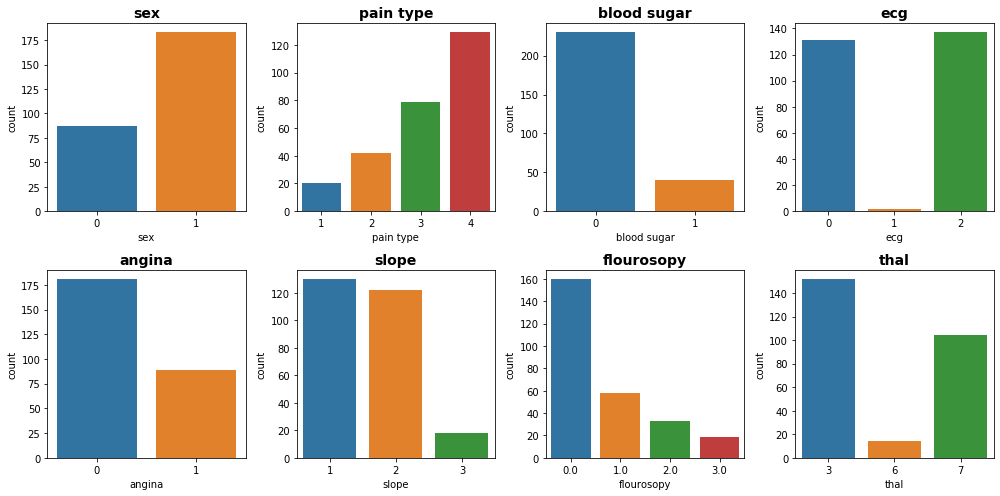

In [ ]:
# посмотрим на распределение категориальных и числовых признаков

nr_rows = 2
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(14,7))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.countplot(df_heart[categorical[i]], ax=ax)
        ax.set_title(categorical[i], fontsize=14, fontweight='bold')
        
plt.tight_layout()

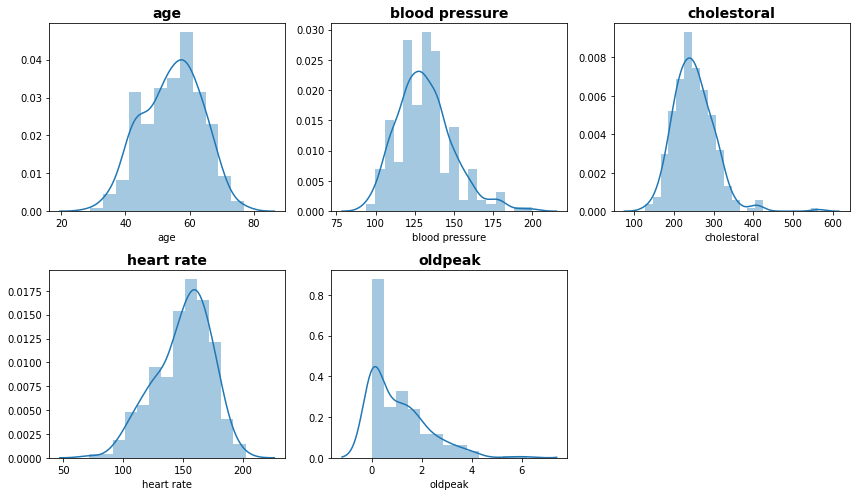

In [ ]:
plt.figure(figsize=(12,7))

plt.subplot(2, 3, 1), sns.distplot(df_heart['age']), plt.title ('age', fontsize=14, fontweight='bold')
plt.subplot(2, 3, 2), sns.distplot(df_heart['blood pressure']), plt.title ('blood pressure', fontsize=14, fontweight='bold')
plt.subplot(2, 3, 3), sns.distplot(df_heart['cholestoral']), plt.title ('cholestoral', fontsize=14, fontweight='bold')
plt.subplot(2, 3, 4), sns.distplot(df_heart['heart rate']), plt.title ('heart rate', fontsize=14, fontweight='bold')
plt.subplot(2, 3, 5), sns.distplot(df_heart['oldpeak']), plt.title ('oldpeak', fontsize=14, fontweight='bold')

plt.tight_layout()

In [ ]:
# заменим числовые признаки на дискретные

est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

X_est_train = est.fit_transform(train_df[numerical])
X_est_test = est.transform(test_df[numerical])
X_est_train = pd.DataFrame(X_est_train, columns=numerical)
X_est_test = pd.DataFrame(X_est_test, columns=numerical)

X_est = pd.concat([X_est_train, X_est_test], axis=0)

X_est.head()

,age,blood pressure,cholestoral,heart rate,oldpeak
0,2.0,0.0,0.0,2.0,1.0
1,2.0,2.0,1.0,1.0,0.0
2,2.0,1.0,0.0,2.0,0.0
3,1.0,3.0,1.0,1.0,2.0
4,0.0,0.0,1.0,2.0,0.0


In [ ]:
# объединим их с остальными признаками и целевым классом

df_est = pd.concat([X_est, df_heart.drop(numerical, axis=1)], axis=1)

df_est.head()

,age,blood pressure,cholestoral,heart rate,oldpeak,sex,pain type,blood sugar,ecg,angina,slope,flourosopy,thal,class
0,2.0,0.0,0.0,2.0,1.0,1,1,0,2,1,2,0.0,3,1
1,2.0,2.0,1.0,1.0,0.0,1,4,0,2,1,2,1.0,6,2
2,2.0,1.0,0.0,2.0,0.0,1,3,0,2,0,2,1.0,7,2
3,1.0,3.0,1.0,1.0,2.0,0,4,0,1,1,2,0.0,3,2
4,0.0,0.0,1.0,2.0,0.0,0,3,0,0,0,2,1.0,3,1


In [ ]:
# применим MultinomialNB

gs_cv_m = GridSearchCV(MultinomialNB(), param_grid={'alpha': np.arange(0.1, 50, 0.1)}, cv=5)
gs_cv_m.fit(df_est.iloc[:test_size, :-1], df_est.iloc[:test_size, -1:])

clf_m = MultinomialNB(**gs_cv_m.best_params_)
clf_m.fit(df_est.iloc[:test_size, :-1], df_est.iloc[:test_size, -1:])
print(gs_cv_m.best_params_)
print(round(clf_m.score(df_est.iloc[:-test_size, :-1], df_est.iloc[:-test_size, -1:]), 2))

{'alpha': 0.1}
0.8


In [ ]:
# применим CategoricalNB

clf = CategoricalNB()
clf.fit(df_est.iloc[:test_size, :-1], df_est.iloc[:test_size, -1:])
print(round(clf.score(df_est.iloc[:-test_size, :-1], df_est.iloc[:-test_size, -1:]), 2))

0.88


In [ ]:
# выделим булевские и не булевские признаки

boolean = ['sex', 'blood sugar', 'angina']
not_boolean = ['pain type', 'ecg', 'slope', 'flourosopy', 'thal']

In [ ]:
# приведем числовые признаки к булевскому типу (для этого n_bins возьмем равным 2)

est_bool = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
X_bool_train = est_bool.fit_transform(train_df[numerical])
X_bool_test = est_bool.transform(test_df[numerical])
X_bool_train = pd.DataFrame(X_bool_train, columns=numerical)
X_bool_test = pd.DataFrame(X_bool_test, columns=numerical)

X_bool = pd.concat([X_bool_train, X_bool_test], axis=0)

X_bool['age'].unique()

array([1., 0.])

In [ ]:
# используем для не булевских признаков get_dummies

X_dumm = pd.get_dummies(df_heart[not_boolean], columns=not_boolean)

X_dumm.head()

,pain type_1,pain type_2,pain type_3,pain type_4,ecg_0,ecg_1,ecg_2,slope_1,slope_2,slope_3,flourosopy_0.0,flourosopy_1.0,flourosopy_2.0,flourosopy_3.0,thal_3,thal_6,thal_7
0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1
3,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0
4,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0


In [ ]:
# объединим все таблицы

df_bool = pd.concat([X_bool, X_dumm, df_heart[boolean], df_heart['class']], axis=1)

df_bool.nunique() # количество уникальных значений признака

age               2
blood pressure    2
cholestoral       2
heart rate        2
oldpeak           2
pain type_1       2
pain type_2       2
pain type_3       2
pain type_4       2
ecg_0             2
ecg_1             2
ecg_2             2
slope_1           2
slope_2           2
slope_3           2
flourosopy_0.0    2
flourosopy_1.0    2
flourosopy_2.0    2
flourosopy_3.0    2
thal_3            2
thal_6            2
thal_7            2
sex               2
blood sugar       2
angina            2
class             2
dtype: int64

In [ ]:
# применим BernoulliNB

clf_b = BernoulliNB()
clf_b.fit(df_bool.iloc[:test_size, :-1], df_bool.iloc[:test_size, -1:])
print(round(clf_b.score(df_bool.iloc[:-test_size, :-1], df_bool.iloc[:-test_size, -1:]), 2))

0.87


In [ ]:
# объединение нескольких классификаторов

clf_gauc = GaussianNB()
clf_cat = CategoricalNB()
clf_bool = BernoulliNB()

In [ ]:
# выделим мультиномиальные признаки

mult = ['pain type', 'ecg', 'slope', 'flourosopy', 'thal']

In [ ]:
# для CategoricalNB и BernoulliNB используем GridSearch

gs_cat = GridSearchCV(clf_cat, param_grid={'alpha': np.arange(0.1, 50, 0.1)}, cv=5)
gs_cat.fit(train_df[mult], train_df['class'])
print(gs_cat.best_params_)

gs_bool = GridSearchCV(clf_bool, param_grid={'alpha': np.arange(0.1, 50, 0.1), 'binarize': np.arange(0.1, 10)}, cv=5)
gs_bool.fit(train_df[boolean], train_df['class'])
print(gs_bool.best_params_)

{'alpha': 25.900000000000002}
{'alpha': 31.300000000000004, 'binarize': 0.1}


In [ ]:
# к числовым признакам применим StandardScaler
# для всех классификаторов посчитаем предсказания классов

pipe_gauc = make_pipeline(StandardScaler(), GaussianNB())

make_pipeline(StandardScaler(), GaussianNB(priors=None))
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

pipe_gauc.fit(train_df[numerical], train_df['class'])
clf_gauc_pred = pipe_gauc.predict_proba(test_df[numerical])
print('Gaussian', round(pipe_gauc.score(test_df[numerical], test_df['class']), 2))

clf_cat = CategoricalNB(**gs_cat.best_params_)
clf_cat.fit(train_df[mult], train_df['class'])
clf_cat_pred = clf_cat.predict_proba(test_df[mult])
print('Categorical', round(clf_cat.score(test_df[mult], test_df['class']), 2))

clf_bool = BernoulliNB(**gs_bool.best_params_)
clf_bool.fit(train_df[boolean], train_df['class'])
clf_bool_pred = clf_bool.predict_proba(test_df[boolean])
print('Bernoulli', round(clf_bool.score(test_df[boolean], test_df['class']), 2))

Gaussian 0.72
Categorical 0.83
Bernoulli 0.7


In [ ]:
# выведем вероятность объединенных классов

mix_pred = clf_gauc_pred * clf_cat_pred * clf_bool_pred
mix_pred_1 = mix_pred[:, 0]
mix_pred_2 = mix_pred[:, 1]

# сохраним в список новые метки классов
class_mark = []

for i in range(len(mix_pred_1)):
  if mix_pred[i, 0] > mix_pred[i, 1]:
    class_mark.append(1)
  else:
    class_mark.append(2)

len(class_mark)

90

In [ ]:
# выведем итоговый accuracy

class_mix_score = accuracy_score(class_mark, test_df['class'])
print('class_mix_score:', round((class_mix_score), 2))

class_mix_score: 0.83


###Accuracy на основании нескольких классов не дает лучшего результата.
###Лучший результат показал класс CategoricalNB с применением KBinsDiscretizer для числовых признаков с параметром n_bins=4.